## 1.Importations  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from matplotlib.gridspec import GridSpec
np.random.seed(42)
import joblib
import pickle
import warnings
warnings.filterwarnings('ignore')

## 2.Chargement + Prétraitement 

In [2]:
df = pd.read_csv('combined_crypto_dataset.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Name', 'Date']).reset_index(drop=True)

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")

Dataset shape: (5151, 10)
Date range: 2013-04-29 23:59:59 to 2021-07-06 23:59:59


## 3.FEATURE ENGINEERING

In [3]:
# === TIME-BASED FEATURES ===
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Quarter'] = df['Date'].dt.quarter

# === PRICE-BASED FEATURES ===
df['Price_Range'] = df['High'] - df['Low']
df['Price_Change'] = df['Close'] - df['Open']
df['Price_Change_Pct'] = (df['Price_Change'] / df['Open']) * 100

# === LAG FEATURES ===
df['MA_7'] = df.groupby('Name')['Close'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
df['MA_30'] = df.groupby('Name')['Close'].transform(lambda x: x.rolling(window=30, min_periods=1).mean())
df['Volatility_7'] = df.groupby('Name')['Close'].transform(lambda x: x.rolling(window=7, min_periods=1).std())
df['Close_Lag1'] = df.groupby('Name')['Close'].shift(1)
df['Close_Lag7'] = df.groupby('Name')['Close'].shift(7)

# === RSI INDICATOR ===
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period, min_periods=1).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period, min_periods=1).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI_14'] = df.groupby('Name')['Close'].transform(lambda x: calculate_rsi(x, 14))
df['RSI_7'] = df.groupby('Name')['Close'].transform(lambda x: calculate_rsi(x, 7))

# === MACD INDICATOR ===
def calculate_macd(series, fast=12, slow=26, signal=9):
    ema_fast = series.ewm(span=fast, min_periods=1, adjust=False).mean()
    ema_slow = series.ewm(span=slow, min_periods=1, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, min_periods=1, adjust=False).mean()
    macd_histogram = macd_line - signal_line
    return macd_line, signal_line, macd_histogram

for crypto in df['Name'].unique():
    mask = df['Name'] == crypto
    macd, signal, hist = calculate_macd(df.loc[mask, 'Close'])
    df.loc[mask, 'MACD'] = macd.values
    df.loc[mask, 'MACD_Signal'] = signal.values
    df.loc[mask, 'MACD_Hist'] = hist.values

# === BOLLINGER BANDS ===
df['BB_Middle'] = df.groupby('Name')['Close'].transform(lambda x: x.rolling(window=20, min_periods=1).mean())
df['BB_Std'] = df.groupby('Name')['Close'].transform(lambda x: x.rolling(window=20, min_periods=1).std())
df['BB_Upper'] = df['BB_Middle'] + (2 * df['BB_Std'])
df['BB_Lower'] = df['BB_Middle'] - (2 * df['BB_Std'])
df['BB_Width'] = (df['BB_Upper'] - df['BB_Lower']) / df['BB_Middle']
df['BB_Position'] = (df['Close'] - df['BB_Lower']) / (df['BB_Upper'] - df['BB_Lower'])

# === VOLUME INDICATORS ===
df['Volume_MA_7'] = df.groupby('Name')['Volume'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
df['Volume_MA_30'] = df.groupby('Name')['Volume'].transform(lambda x: x.rolling(window=30, min_periods=1).mean())
df['Volume_Ratio'] = df['Volume'] / df['Volume_MA_7']
df['Volume_Trend'] = df['Volume_MA_7'] / df['Volume_MA_30']

# === MOMENTUM INDICATORS ===
df['ROC_7'] = df.groupby('Name')['Close'].transform(lambda x: ((x - x.shift(7)) / x.shift(7)) * 100)
df['ROC_14'] = df.groupby('Name')['Close'].transform(lambda x: ((x - x.shift(14)) / x.shift(14)) * 100)
df['Momentum_7'] = df.groupby('Name')['Close'].transform(lambda x: x - x.shift(7))
df['Price_Acceleration'] = df.groupby('Name')['Close'].transform(lambda x: x.diff().diff())

# === TREND STRENGTH ===
df['MA_Ratio'] = df['MA_7'] / df['MA_30']
df['Price_vs_MA7'] = (df['Close'] - df['MA_7']) / df['MA_7'] * 100
df['Price_vs_MA30'] = (df['Close'] - df['MA_30']) / df['MA_30'] * 100

# === VOLATILITY ===
df['ATR_14'] = df.groupby('Name')['Price_Range'].transform(lambda x: x.rolling(window=14, min_periods=1).mean())
df['Volatility_Ratio'] = df['Volatility_7'] / df['Close']

# === SENTIMENT INDICATORS ===
df['Fear_Index'] = (df['Volatility_7'] / df['Close']) * 100
df['Greed_Index'] = df['ROC_7'].clip(lower=0)
df['Sentiment_Change'] = df.groupby('Name')['ROC_7'].transform(lambda x: x.diff())
df['Panic_Selling'] = ((df['Volume_Ratio'] > 1.5) & (df['Price_Change_Pct'] < -2)).astype(int)
df['FOMO_Buying'] = ((df['Volume_Ratio'] > 1.5) & (df['Price_Change_Pct'] > 2)).astype(int)
df['Sentiment_Score'] = (
    (df['RSI_14'] - 50) / 50 +
    (df['Price_vs_MA7'] / 100) +
    (df['Volume_Ratio'] - 1) * 0.5
)

# === ON-CHAIN PROXIES ===
df['Volume_Velocity'] = df.groupby('Name')['Volume'].transform(lambda x: x.pct_change(periods=7))
df['Activity_Level'] = df.groupby('Name')['Volume'].transform(lambda x: (x / x.rolling(30, min_periods=1).mean()))
df['Value_Transferred'] = df['Close'] * df['Volume']
df['Value_Transferred_MA7'] = df.groupby('Name')['Value_Transferred'].transform(lambda x: x.rolling(7, min_periods=1).mean())
df['Value_Transfer_Ratio'] = df['Value_Transferred'] / df['Value_Transferred_MA7']

# === MACRO INDICATORS ===
df['Relative_Strength'] = df.groupby('Date')['ROC_7'].transform(lambda x: (x - x.mean()) / (x.std() + 1e-6))
df['Market_Sync'] = df.groupby('Date')['Price_Change_Pct'].transform(lambda x: abs(x - x.median()))
df['Volume_Market_Share'] = df.groupby('Date')['Volume'].transform(lambda x: x / x.sum())
df['Market_Dispersion'] = df.groupby('Date')['Price_Change_Pct'].transform('std')
df['Market_Volatility'] = df.groupby('Date')['Volatility_7'].transform('mean')
df['Risk_Appetite'] = -df['Market_Volatility']

# === DERIVATIVES PROXIES ===
df['Volatility_Cluster'] = df.groupby('Name')['Volatility_7'].transform(lambda x: x.rolling(3, min_periods=1).mean()) / df['Volatility_7']
df['Price_MA_Deviation'] = (df['Close'] - df['MA_30']) / df['MA_30'] * 100
df['OI_Proxy'] = df.groupby('Name')['Volatility_7'].transform(lambda x: x.rolling(14, min_periods=1).mean())
df['Speculation_Index'] = np.log1p(df['Volume']) / np.log1p(df['Close'])
df['Futures_Premium_Proxy'] = df['Price_Acceleration'] / (df['Close'] + 1)

# Handle missing values
df = df.replace([np.inf, -np.inf], np.nan)
df = df.fillna(method='ffill').fillna(method='bfill').fillna(0)

print(f"✅ Features engineered. Total columns: {len(df.columns)}")

✅ Features engineered. Total columns: 69


## 4.Preparation de donnees 

In [4]:
# Create binary target: Price goes UP (1) or DOWN (0)
df['Next_Close'] = df.groupby('Name')['Close'].shift(-1)
df['Price_Direction'] = (df['Next_Close'] > df['Close']).astype(int)
df['Next_Day_Change_Pct'] = ((df['Next_Close'] - df['Close']) / df['Close']) * 100

# Remove rows without next day price
df = df.dropna(subset=['Next_Close', 'Close_Lag1']).reset_index(drop=True)

# Select all features
basic_features = ['High', 'Low', 'Open', 'Volume', 'Marketcap', 'Year', 'Month', 'Day', 
                  'DayOfWeek', 'Quarter', 'Price_Range', 'Price_Change', 'Price_Change_Pct']
simple_tech = ['MA_7', 'MA_30', 'Volatility_7', 'Close_Lag1', 'Close_Lag7']
advanced_tech = ['RSI_14', 'RSI_7', 'MACD', 'MACD_Signal', 'MACD_Hist', 'BB_Width', 'BB_Position',
                 'Volume_Ratio', 'Volume_Trend', 'ROC_7', 'ROC_14', 'Momentum_7', 'Price_Acceleration',
                 'MA_Ratio', 'Price_vs_MA7', 'Price_vs_MA30', 'ATR_14', 'Volatility_Ratio']
market_features = ['Fear_Index', 'Greed_Index', 'Sentiment_Change', 'Panic_Selling', 'FOMO_Buying',
                   'Sentiment_Score', 'Volume_Velocity', 'Activity_Level', 'Value_Transfer_Ratio',
                   'Relative_Strength', 'Market_Sync', 'Volume_Market_Share', 'Market_Dispersion',
                   'Market_Volatility', 'Risk_Appetite', 'Volatility_Cluster', 'Price_MA_Deviation',
                   'OI_Proxy', 'Speculation_Index', 'Futures_Premium_Proxy']

feature_cols = basic_features + simple_tech + advanced_tech + market_features

X = df[feature_cols]
y = df['Price_Direction'].values

# Temporal split (no shuffling for time series!)
df_sorted = df.sort_values('Date').reset_index(drop=True)
split_idx = int(len(df_sorted) * 0.8)

train_df = df_sorted.iloc[:split_idx]
test_df = df_sorted.iloc[split_idx:]

X_train = train_df[feature_cols].values
y_train = train_df['Price_Direction'].values

X_test = test_df[feature_cols].values
y_test = test_df['Price_Direction'].values

# Scale features (fit only on train!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✅ Data prepared for modeling")
print(f"Train shape: {X_train_scaled.shape}, Test shape: {X_test_scaled.shape}")



✅ Data prepared for modeling
Train shape: (4119, 56), Test shape: (1030, 56)


## 5. MODEL PREDICTIONS & COMPARISON

In [5]:
# 5.1 Entrainement des models 

print("="*80)
print("TRAINING MULTIPLE PREDICTION MODELS")
print("="*80)

# Dictionary to store models
models_dict = {}
predictions_dict = {}
metrics_dict = {}

#M1 Random Forest 

print("\n📊 Model 1: Random Forest Classifier...")
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=20,
    min_samples_leaf=10,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)
rf_pred_train = rf_model.predict(X_train_scaled)
rf_pred_test = rf_model.predict(X_test_scaled)
rf_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

models_dict['Random Forest'] = rf_model
predictions_dict['Random Forest'] = {'train': rf_pred_train, 'test': rf_pred_test, 'proba': rf_pred_proba}
metrics_dict['Random Forest'] = {
    'train_acc': accuracy_score(y_train, rf_pred_train),
    'test_acc': accuracy_score(y_test, rf_pred_test),
    'test_f1': f1_score(y_test, rf_pred_test, zero_division=0),
    'test_recall': recall_score(y_test, rf_pred_test, zero_division=0),
    'test_precision': precision_score(y_test, rf_pred_test, zero_division=0),
    'balanced_acc': balanced_accuracy_score(y_test, rf_pred_test)
}
print(f"✅ RF - Test Acc: {metrics_dict['Random Forest']['test_acc']:.3f}, F1: {metrics_dict['Random Forest']['test_f1']:.3f}")


#M2 XGBoost 

scale_weight = (y_train == 0).sum() / (y_train == 1).sum() 
print("\n📊 Model 2: XGBoost with SMOTE...")
xgb_model = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=7,
    gamma=0.3,
    scale_pos_weight=scale_weight,
    reg_alpha=0.1,
    reg_lambda=1.5,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss',
    tree_method='hist',
    objective='binary:logistic'
)


smote = SMOTE(random_state=42, k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)


xgb_model.fit(X_train_balanced, y_train_balanced)
xgb_pred_train = xgb_model.predict(X_train_scaled)
xgb_pred_test = xgb_model.predict(X_test_scaled)
xgb_pred_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

models_dict['XGBoost'] = xgb_model
predictions_dict['XGBoost'] = {'train': xgb_pred_train, 'test': xgb_pred_test, 'proba': xgb_pred_proba}
metrics_dict['XGBoost'] = {
    'train_acc': accuracy_score(y_train, xgb_pred_train),
    'test_acc': accuracy_score(y_test, xgb_pred_test),
    'test_f1': f1_score(y_test, xgb_pred_test, zero_division=0),
    'test_recall': recall_score(y_test, xgb_pred_test, zero_division=0),
    'test_precision': precision_score(y_test, xgb_pred_test, zero_division=0),
    'balanced_acc': balanced_accuracy_score(y_test, xgb_pred_test)
}
print(f" XGB - Test Acc: {metrics_dict['XGBoost']['test_acc']:.3f}, F1: {metrics_dict['XGBoost']['test_f1']:.3f}")


#M3 Gradient Boosting 

print("\n Model 3: Gradient Boosting Classifier...")
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10,
    subsample=0.8,
    random_state=42
)
gb_model.fit(X_train_scaled, y_train)
gb_pred_train = gb_model.predict(X_train_scaled)
gb_pred_test = gb_model.predict(X_test_scaled)
gb_pred_proba = gb_model.predict_proba(X_test_scaled)[:, 1]

models_dict['Gradient Boosting'] = gb_model
predictions_dict['Gradient Boosting'] = {'train': gb_pred_train, 'test': gb_pred_test, 'proba': gb_pred_proba}
metrics_dict['Gradient Boosting'] = {
    'train_acc': accuracy_score(y_train, gb_pred_train),
    'test_acc': accuracy_score(y_test, gb_pred_test),
    'test_f1': f1_score(y_test, gb_pred_test, zero_division=0),
    'test_recall': recall_score(y_test, gb_pred_test, zero_division=0),
    'test_precision': precision_score(y_test, gb_pred_test, zero_division=0),
    'balanced_acc': balanced_accuracy_score(y_test, gb_pred_test)
}
print(f" GB - Test Acc: {metrics_dict['Gradient Boosting']['test_acc']:.3f}, F1: {metrics_dict['Gradient Boosting']['test_f1']:.3f}")


#M4 Logistic Regression

print("\n Model 4: Logistic Regression...")
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
lr_model.fit(X_train_scaled, y_train)
lr_pred_train = lr_model.predict(X_train_scaled)
lr_pred_test = lr_model.predict(X_test_scaled)
lr_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

models_dict['Logistic Regression'] = lr_model
predictions_dict['Logistic Regression'] = {'train': lr_pred_train, 'test': lr_pred_test, 'proba': lr_pred_proba}
metrics_dict['Logistic Regression'] = {
    'train_acc': accuracy_score(y_train, lr_pred_train),
    'test_acc': accuracy_score(y_test, lr_pred_test),
    'test_f1': f1_score(y_test, lr_pred_test, zero_division=0),
    'test_recall': recall_score(y_test, lr_pred_test, zero_division=0),
    'test_precision': precision_score(y_test, lr_pred_test, zero_division=0),
    'balanced_acc': balanced_accuracy_score(y_test, lr_pred_test)
}
print(f" LR - Test Acc: {metrics_dict['Logistic Regression']['test_acc']:.3f}, F1: {metrics_dict['Logistic Regression']['test_f1']:.3f}")


#M5 SVM

print("\n Model 5: Support Vector Machine...")
from sklearn.svm import SVC

svm_model = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    class_weight='balanced',
    probability=True,
    random_state=42
)
svm_model.fit(X_train_scaled, y_train)
svm_pred_train = svm_model.predict(X_train_scaled)
svm_pred_test = svm_model.predict(X_test_scaled)
svm_pred_proba = svm_model.predict_proba(X_test_scaled)[:, 1]

models_dict['SVM'] = svm_model
predictions_dict['SVM'] = {'train': svm_pred_train, 'test': svm_pred_test, 'proba': svm_pred_proba}
metrics_dict['SVM'] = {
    'train_acc': accuracy_score(y_train, svm_pred_train),
    'test_acc': accuracy_score(y_test, svm_pred_test),
    'test_f1': f1_score(y_test, svm_pred_test, zero_division=0),
    'test_recall': recall_score(y_test, svm_pred_test, zero_division=0),
    'test_precision': precision_score(y_test, svm_pred_test, zero_division=0),
    'balanced_acc': balanced_accuracy_score(y_test, svm_pred_test)
}
print(f" SVM - Test Acc: {metrics_dict['SVM']['test_acc']:.3f}, F1: {metrics_dict['SVM']['test_f1']:.3f}")

print("\n" + "="*80)
print(" ALL 5 MODELS TRAINED SUCCESSFULLY!")
print("="*80)

TRAINING MULTIPLE PREDICTION MODELS

📊 Model 1: Random Forest Classifier...
✅ RF - Test Acc: 0.494, F1: 0.486

📊 Model 2: XGBoost with SMOTE...


  File "c:\Users\Aloulou\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\Aloulou\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Aloulou\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cwd, env,
                        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
                        gid, gids, uid, umask,
                        ^^^^^^^^^^^^^^^^^^^^^^
                        start_new_session, process_group)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Aloulou\anaconda3\Lib\sub

 XGB - Test Acc: 0.513, F1: 0.508

 Model 3: Gradient Boosting Classifier...
 GB - Test Acc: 0.497, F1: 0.479

 Model 4: Logistic Regression...
 LR - Test Acc: 0.483, F1: 0.335

 Model 5: Support Vector Machine...
 SVM - Test Acc: 0.507, F1: 0.560

 ALL 5 MODELS TRAINED SUCCESSFULLY!


In [6]:
# 5.2 COMPARAISON


print("\n" + "="*80)
print(" MODEL COMPARISON - ALL METRICS")
print("="*80)

comparison_models = pd.DataFrame({
    'Model': list(metrics_dict.keys()),
    'Train Acc': [metrics_dict[m]['train_acc'] for m in metrics_dict.keys()],
    'Test Acc': [metrics_dict[m]['test_acc'] for m in metrics_dict.keys()],
    'Balanced Acc': [metrics_dict[m]['balanced_acc'] for m in metrics_dict.keys()],
    'Precision': [metrics_dict[m]['test_precision'] for m in metrics_dict.keys()],
    'Recall': [metrics_dict[m]['test_recall'] for m in metrics_dict.keys()],
    'F1-Score': [metrics_dict[m]['test_f1'] for m in metrics_dict.keys()],
})

comparison_models = comparison_models.sort_values('F1-Score', ascending=False).reset_index(drop=True)

print("\n" + comparison_models.to_string(index=False))

print("\n" + "="*80)
print(" RANKING BY F1-SCORE (Best for imbalanced classification):")
print("="*80)
for idx, row in comparison_models.iterrows():
    print(f"{idx+1}. {row['Model']:20s} - F1: {row['F1-Score']:.4f}, Acc: {row['Test Acc']:.4f}, Balanced: {row['Balanced Acc']:.4f}")

# Get best model
best_model_name = comparison_models.iloc[0]['Model']
print(f"\n BEST MODEL: {best_model_name}")
print("="*80)


 MODEL COMPARISON - ALL METRICS

              Model  Train Acc  Test Acc  Balanced Acc  Precision   Recall  F1-Score
                SVM   0.634134  0.506796      0.499574   0.555938 0.563700  0.559792
            XGBoost   0.905074  0.512621      0.520314   0.579418 0.452007  0.507843
      Random Forest   0.937849  0.494175      0.502406   0.559091 0.429319  0.485686
  Gradient Boosting   0.910415  0.497087      0.507460   0.565321 0.415358  0.478873
Logistic Regression   0.569798  0.482524      0.514084   0.587719 0.233857  0.334582

 RANKING BY F1-SCORE (Best for imbalanced classification):
1. SVM                  - F1: 0.5598, Acc: 0.5068, Balanced: 0.4996
2. XGBoost              - F1: 0.5078, Acc: 0.5126, Balanced: 0.5203
3. Random Forest        - F1: 0.4857, Acc: 0.4942, Balanced: 0.5024
4. Gradient Boosting    - F1: 0.4789, Acc: 0.4971, Balanced: 0.5075
5. Logistic Regression  - F1: 0.3346, Acc: 0.4825, Balanced: 0.5141

 BEST MODEL: SVM


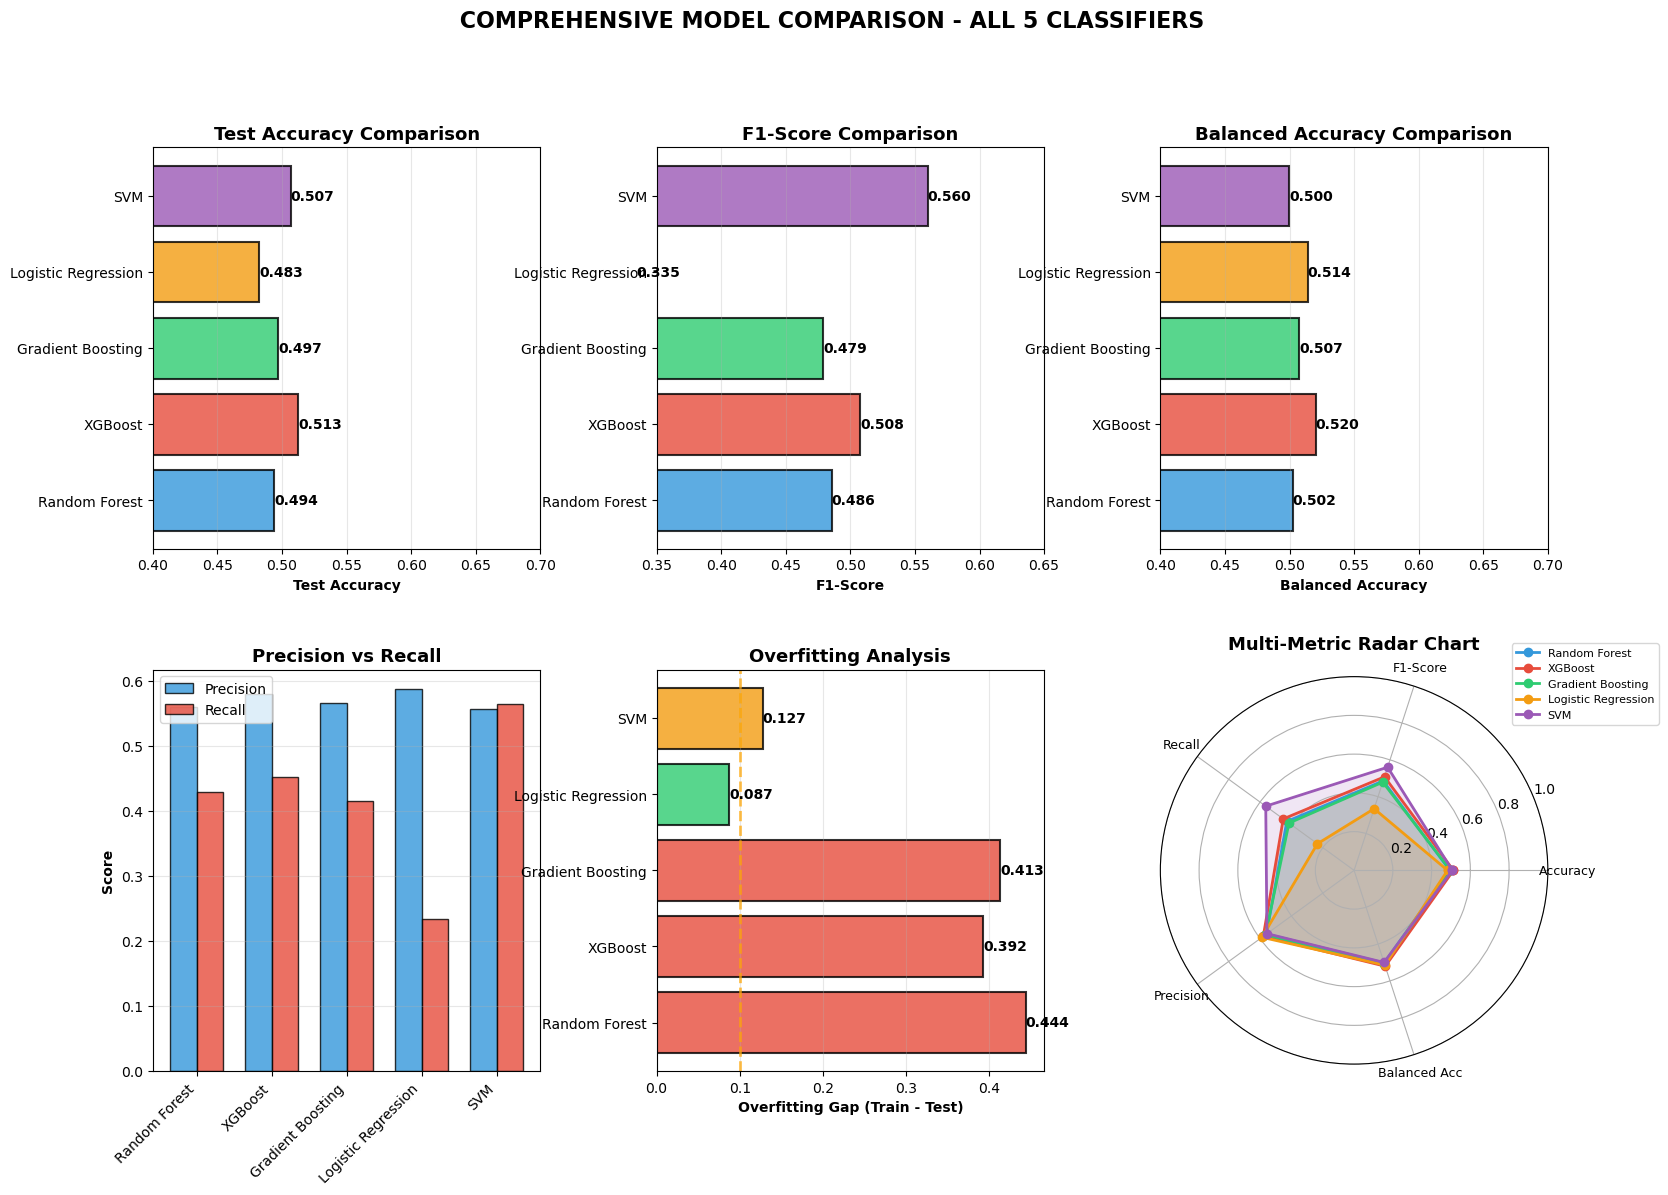


 Model comparison visualization created!


In [7]:
# 5.3 VISUALIZATION

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

models_list = list(metrics_dict.keys())
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']

# 1. Comparison Accuracy
ax1 = fig.add_subplot(gs[0, 0])
test_accs = [metrics_dict[m]['test_acc'] for m in models_list]
bars = ax1.barh(models_list, test_accs, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Test Accuracy', fontweight='bold')
ax1.set_title('Test Accuracy Comparison', fontweight='bold', fontsize=13)
ax1.set_xlim([0.4, 0.7])
for i, (bar, val) in enumerate(zip(bars, test_accs)):
    ax1.text(val, i, f'{val:.3f}', ha='left', va='center', fontweight='bold', fontsize=10)
ax1.grid(axis='x', alpha=0.3)

# 2.  Comparison F1-Score
ax2 = fig.add_subplot(gs[0, 1])
f1_scores = [metrics_dict[m]['test_f1'] for m in models_list]
bars = ax2.barh(models_list, f1_scores, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_xlabel('F1-Score', fontweight='bold')
ax2.set_title('F1-Score Comparison', fontweight='bold', fontsize=13)
ax2.set_xlim([0.35, 0.65])
for i, (bar, val) in enumerate(zip(bars, f1_scores)):
    ax2.text(val, i, f'{val:.3f}', ha='left', va='center', fontweight='bold', fontsize=10)
ax2.grid(axis='x', alpha=0.3)

# 3.  Comparison Balanced Accuracy
ax3 = fig.add_subplot(gs[0, 2])
balanced_accs = [metrics_dict[m]['balanced_acc'] for m in models_list]
bars = ax3.barh(models_list, balanced_accs, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax3.set_xlabel('Balanced Accuracy', fontweight='bold')
ax3.set_title('Balanced Accuracy Comparison', fontweight='bold', fontsize=13)
ax3.set_xlim([0.4, 0.7])
for i, (bar, val) in enumerate(zip(bars, balanced_accs)):
    ax3.text(val, i, f'{val:.3f}', ha='left', va='center', fontweight='bold', fontsize=10)
ax3.grid(axis='x', alpha=0.3)

# 4. Precision vs Recall
ax4 = fig.add_subplot(gs[1, 0])
precisions = [metrics_dict[m]['test_precision'] for m in models_list]
recalls = [metrics_dict[m]['test_recall'] for m in models_list]
x_pos = np.arange(len(models_list))
width = 0.35
bars1 = ax4.bar(x_pos - width/2, precisions, width, label='Precision', color='#3498db', alpha=0.8, edgecolor='black')
bars2 = ax4.bar(x_pos + width/2, recalls, width, label='Recall', color='#e74c3c', alpha=0.8, edgecolor='black')
ax4.set_ylabel('Score', fontweight='bold')
ax4.set_title('Precision vs Recall', fontweight='bold', fontsize=13)
ax4.set_xticks(x_pos)
ax4.set_xticklabels(models_list, rotation=45, ha='right')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# 5. Train vs Test Accuracy (Overfitting)
ax5 = fig.add_subplot(gs[1, 1])
train_accs = [metrics_dict[m]['train_acc'] for m in models_list]
overfitting = [train_accs[i] - test_accs[i] for i in range(len(models_list))]
bars = ax5.barh(models_list, overfitting, color=['#2ecc71' if v < 0.1 else '#f39c12' if v < 0.2 else '#e74c3c' for v in overfitting], 
                 alpha=0.8, edgecolor='black', linewidth=1.5)
ax5.set_xlabel('Overfitting Gap (Train - Test)', fontweight='bold')
ax5.set_title('Overfitting Analysis', fontweight='bold', fontsize=13)
ax5.axvline(x=0.1, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='Moderate threshold')
for i, (bar, val) in enumerate(zip(bars, overfitting)):
    ax5.text(val, i, f'{val:.3f}', ha='left', va='center', fontweight='bold', fontsize=10)
ax5.grid(axis='x', alpha=0.3)

# 6. All Metrics Radar Chart
ax6 = fig.add_subplot(gs[1, 2], projection='polar')
categories = ['Accuracy', 'F1-Score', 'Recall', 'Precision', 'Balanced Acc']
angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]

for idx, model in enumerate(models_list):
    values = [
        metrics_dict[model]['test_acc'],
        metrics_dict[model]['test_f1'],
        metrics_dict[model]['test_recall'],
        metrics_dict[model]['test_precision'],
        metrics_dict[model]['balanced_acc']
    ]
    values += values[:1]
    ax6.plot(angles, values, 'o-', linewidth=2, label=model, color=colors[idx])
    ax6.fill(angles, values, alpha=0.15, color=colors[idx])

ax6.set_xticks(angles[:-1])
ax6.set_xticklabels(categories, size=9)
ax6.set_ylim(0, 1)
ax6.set_title('Multi-Metric Radar Chart', fontweight='bold', fontsize=13, pad=20)
ax6.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=8)
ax6.grid(True)

plt.suptitle(' COMPREHENSIVE MODEL COMPARISON - ALL 5 CLASSIFIERS', fontsize=16, fontweight='bold', y=0.995)
plt.show()

print("\n Model comparison visualization created!")

In [8]:
# 5.4 SAVE BEST MODEL


best_model = models_dict[best_model_name]

# Enregistrer  model
model_filename = f'best_prediction_model_{best_model_name.replace(" ", "_")}.pkl'
joblib.dump(best_model, model_filename)

# Enregistrer scaler
scaler_filename = 'scaler_predictions.pkl'
joblib.dump(scaler, scaler_filename)

# Enregistrer feature columns
features_filename = 'feature_columns.pkl'
with open(features_filename, 'wb') as f:
    pickle.dump(feature_cols, f)

print("\n" + "="*80)
print("BEST MODEL SAVED")
print("="*80)
print(f"Model: {best_model_name}")
print(f" Saved: {model_filename}")
print(f" Saved: {scaler_filename}")
print(f" Saved: {features_filename}")
print("="*80)


BEST MODEL SAVED
Model: SVM
 Saved: best_prediction_model_SVM.pkl
 Saved: scaler_predictions.pkl
 Saved: feature_columns.pkl


In [9]:
# 5.9 FUTURE PREDICTION - NEXT DAY ONLY (FIXED)

def predict_next_day(crypto_name, neutral_threshold=0.1, seed=None):
    """
    Predict price movement for the NEXT DAY (last_date + 1)
    Optional seed for reproducibility.
    """
    try:
        # Ensure required objects exist
        missing = [name for name in ('best_model', 'scaler', 'feature_cols') if name not in globals()]
        if missing:
            print(f"Cannot run predict_next_day — missing: {', '.join(missing)}")
            return None

        if seed is not None:
            np.random.seed(seed)

        crypto_data = df_sorted[df_sorted['Name'] == crypto_name].copy().reset_index(drop=True)
        if len(crypto_data) == 0:
            print(f" No data found for {crypto_name}")
            return None

        last_row = crypto_data.iloc[-1].copy()
        last_date = last_row['Date']
        last_price = last_row['Close']

        hist_volatility = crypto_data['Price_Change_Pct'].std()
        hist_mean_change = crypto_data['Price_Change_Pct'].mean()

        next_date = last_date + pd.Timedelta(days=1)
        pred_row = last_row.copy()

        random_change = np.random.normal(hist_mean_change, hist_volatility/2)
        estimated_price = last_price * (1 + random_change / 100)

        pred_row['Close'] = estimated_price
        pred_row['Open'] = last_price
        pred_row['High'] = max(last_price, estimated_price) * (1 + hist_volatility/200)
        pred_row['Low'] = min(last_price, estimated_price) * (1 - hist_volatility/200)
        pred_row['Price_Change'] = estimated_price - last_price

        price_change_pct = (estimated_price - last_price) / last_price * 100 if last_price != 0 else 0.0
        pred_row['Price_Change_Pct'] = price_change_pct
        pred_row['Price_Range'] = pred_row['High'] - pred_row['Low']

        pred_row['Date'] = next_date
        pred_row['Day'] = next_date.day
        pred_row['Month'] = next_date.month
        pred_row['DayOfWeek'] = next_date.dayofweek
        pred_row['Year'] = next_date.year
        pred_row['Quarter'] = next_date.quarter

        prices_list = list(crypto_data['Close'].tail(7).values)
        ma_7 = np.mean(prices_list + [estimated_price])
        prices_list_30 = list(crypto_data['Close'].tail(30).values)
        ma_30_approx = np.mean(prices_list_30 + [estimated_price])

        pred_row['MA_7'] = ma_7
        pred_row['MA_30'] = ma_30_approx
        pred_row['MA_Ratio'] = ma_7 / ma_30_approx if ma_30_approx != 0 else 1.0
        pred_row['Close_Lag1'] = last_price
        pred_row['Close_Lag7'] = crypto_data['Close'].iloc[-7] if len(crypto_data) >= 7 else last_price

        pred_row['ROC_7'] = price_change_pct * np.random.uniform(0.8, 1.2)
        pred_row['ROC_14'] = pred_row['ROC_7'] * np.random.uniform(0.9, 1.1)
        pred_row['Momentum_7'] = estimated_price - last_price
        pred_row['Price_Acceleration'] = (estimated_price - last_price) * np.random.uniform(-1, 1)

        pred_row['Price_vs_MA7'] = ((estimated_price - ma_7) / ma_7 * 100) if ma_7 != 0 else 0
        pred_row['Price_vs_MA30'] = ((estimated_price - ma_30_approx) / ma_30_approx * 100) if ma_30_approx != 0 else 0

        pred_row['Volatility_7'] = hist_volatility * np.random.uniform(0.8, 1.2)
        pred_row['Volatility_Ratio'] = pred_row['Volatility_7'] / estimated_price if estimated_price != 0 else 0
        pred_row['ATR_14'] = pred_row['Volatility_7'] * 0.7

        rsi_value = 50 + (price_change_pct * 3)
        rsi_value = np.clip(rsi_value, 20, 80)
        pred_row['RSI_14'] = rsi_value
        pred_row['RSI_7'] = np.clip(rsi_value + np.random.uniform(-5, 5), 20, 80)

        pred_row['Volume'] = last_row['Volume'] * np.random.uniform(0.7, 1.3)
        pred_row['Volume_MA_7'] = pred_row['Volume'] * np.random.uniform(0.9, 1.1)
        pred_row['Volume_MA_30'] = pred_row['Volume_MA_7'] * np.random.uniform(0.9, 1.1)
        pred_row['Volume_Ratio'] = pred_row['Volume'] / pred_row['Volume_MA_7'] if pred_row['Volume_MA_7'] != 0 else 1.0
        pred_row['Volume_Trend'] = pred_row['Volume_MA_7'] / pred_row['Volume_MA_30'] if pred_row['Volume_MA_30'] != 0 else 1.0
        pred_row['Volume_Velocity'] = (pred_row['Volume'] - last_row['Volume']) / last_row['Volume'] if last_row['Volume'] != 0 else 0
        pred_row['Activity_Level'] = pred_row['Volume'] / pred_row['Volume_MA_7'] if pred_row['Volume_MA_7'] != 0 else 1.0

        pred_row['MACD'] = pred_row.get('MACD', 0) * 0.95 + (price_change_pct * 0.05)
        pred_row['MACD_Signal'] = pred_row['MACD'] * np.random.uniform(0.95, 1.05)
        pred_row['MACD_Hist'] = pred_row['MACD'] - pred_row['MACD_Signal']

        pred_row['BB_Middle'] = ma_7
        pred_row['BB_Std'] = pred_row['Volatility_7']
        pred_row['BB_Upper'] = pred_row['BB_Middle'] + (2 * pred_row['BB_Std'])
        pred_row['BB_Lower'] = pred_row['BB_Middle'] - (2 * pred_row['BB_Std'])
        pred_row['BB_Width'] = (pred_row['BB_Upper'] - pred_row['BB_Lower']) / pred_row['BB_Middle'] if pred_row['BB_Middle'] != 0 else 0
        bb_position = (estimated_price - pred_row['BB_Lower']) / (pred_row['BB_Upper'] - pred_row['BB_Lower']) if (pred_row['BB_Upper'] - pred_row['BB_Lower']) != 0 else 0.5
        pred_row['BB_Position'] = np.clip(bb_position, 0, 1)

        pred_row['Fear_Index'] = (pred_row['Volatility_7'] / estimated_price * 100) if estimated_price != 0 else 0
        pred_row['Greed_Index'] = max(pred_row['ROC_7'], 0)
        pred_row['Sentiment_Change'] = pred_row['ROC_7'] * np.random.uniform(0.8, 1.2)
        pred_row['Panic_Selling'] = 1 if (pred_row['Volume_Ratio'] > 1.5 and price_change_pct < -2) else 0
        pred_row['FOMO_Buying'] = 1 if (pred_row['Volume_Ratio'] > 1.5 and price_change_pct > 2) else 0
        pred_row['Sentiment_Score'] = ((rsi_value - 50) / 50 + pred_row['Price_vs_MA7'] / 100 + (pred_row['Volume_Ratio'] - 1) * 0.5) / 3

        pred_row['Value_Transferred'] = estimated_price * pred_row['Volume']
        pred_row['Value_Transferred_MA7'] = pred_row['Value_Transferred'] * 0.9
        pred_row['Value_Transfer_Ratio'] = pred_row['Value_Transferred'] / pred_row['Value_Transferred_MA7'] if pred_row['Value_Transferred_MA7'] != 0 else 1.0

        pred_row['Relative_Strength'] = (pred_row['ROC_7'] - hist_mean_change) / (hist_volatility + 1e-6)
        pred_row['Market_Sync'] = abs(price_change_pct - hist_mean_change)
        pred_row['Market_Dispersion'] = hist_volatility
        pred_row['Market_Volatility'] = hist_volatility
        pred_row['Risk_Appetite'] = -hist_volatility

        pred_row['Volatility_Cluster'] = (pred_row['Volatility_7'] / hist_volatility) if hist_volatility != 0 else 1.0
        pred_row['Price_MA_Deviation'] = pred_row['Price_vs_MA30']
        pred_row['OI_Proxy'] = pred_row['Volatility_7']
        pred_row['Speculation_Index'] = np.log1p(pred_row['Volume']) / np.log1p(estimated_price) if estimated_price > 0 else 0
        pred_row['Futures_Premium_Proxy'] = pred_row['Price_Acceleration'] / (estimated_price + 1) if estimated_price != 0 else 0

        features_values = pred_row[feature_cols].values.reshape(1, -1)
        features_scaled = scaler.transform(features_values)

        pred_class = best_model.predict(features_scaled)[0]
        pred_proba = best_model.predict_proba(features_scaled)[0]

        class_prob_map = dict(zip(best_model.classes_, pred_proba))
        up_prob = class_prob_map.get(1, 0.0)
        down_prob = class_prob_map.get(0, 0.0)
        confidence = max(up_prob, down_prob)

        if abs(price_change_pct) <= neutral_threshold:
            price_direction = "NEUTRAL"
        elif price_change_pct > 0:
            price_direction = "UP"
        else:
            price_direction = "DOWN"

        model_direction = "UP" if up_prob > down_prob else "DOWN"

        if price_direction == model_direction:
            direction = price_direction
        else:
            direction = f"{price_direction} (Model: {model_direction})"

        confidence_tag = "" if confidence >= 0.6 else " (LOW)"

        result = {
            'Cryptocurrency': crypto_name,
            'Last Date': last_date.strftime('%Y-%m-%d'),
            'Prediction Date': next_date.strftime('%Y-%m-%d'),
            'Last Price': f"${last_price:.2f}",
            'Predicted Price': f"${estimated_price:.2f}",
            'Price Change': f"{price_change_pct:+.2f}%",
            'Price_Direction': price_direction,
            'Model_Direction': model_direction,
            'Direction': direction,
            'Confidence': f"{confidence*100:.2f}%{confidence_tag}",
            'UP Probability': f"{up_prob*100:.2f}%",
            'DOWN Probability': f"{down_prob*100:.2f}%",
            'RSI_14': f"{rsi_value:.1f}",
            'MA_7': f"${ma_7:.2f}",
            'MA_30': f"${ma_30_approx:.2f}"
        }

        return result

    except Exception as e:
        print(f" Error in {crypto_name}: {str(e)}")
        import traceback
        traceback.print_exc()
        return None


In [10]:
# 5.10/BTC



print("\n" + "="*80)
print(" BITCOIN PREDICTION - NEXT DAY")
print("="*80)

bitcoin_prediction = predict_next_day('Bitcoin')

if bitcoin_prediction is not None:
    print(f"\n Prediction Date: {bitcoin_prediction['Prediction Date']}")
    print(f" Last Price: {bitcoin_prediction['Last Price']}")
    print(f" Predicted Price: {bitcoin_prediction['Predicted Price']}")
    print(f" Expected Change: {bitcoin_prediction['Price Change']}")
    print(f"  Price Direction: {bitcoin_prediction['Price_Direction']}")
    print(f"  Model Direction: {bitcoin_prediction['Model_Direction']}")
    print(f"  Final Direction: {bitcoin_prediction['Direction']}")
    print(f" Confidence: {bitcoin_prediction['Confidence']}")
    print(f" UP Probability: {bitcoin_prediction['UP Probability']}")
    print(f" DOWN Probability: {bitcoin_prediction['DOWN Probability']}")
    print(f" RSI_14: {bitcoin_prediction['RSI_14']}")
    print(f" MA_7: {bitcoin_prediction['MA_7']}")
    print(f" MA_30: {bitcoin_prediction['MA_30']}")
else:
    print(" Bitcoin prediction not available")

print("\n" + "="*80)


 BITCOIN PREDICTION - NEXT DAY

 Prediction Date: 2021-07-06
 Last Price: $33746.00
 Predicted Price: $34192.70
 Expected Change: +1.32%
  Price Direction: UP
  Model Direction: UP
  Final Direction: UP
 Confidence: 53.02% (LOW)
 UP Probability: 53.02%
 DOWN Probability: 46.98%
 RSI_14: 54.0
 MA_7: $34534.10
 MA_30: $35316.25



In [11]:
# ETH
print("\n" + "="*80)
print(" ETHEREUM PREDICTION - NEXT DAY")
print("="*80)

ethereum_prediction = predict_next_day('Ethereum')

if ethereum_prediction is not None:
    print(f"\n Prediction Date: {ethereum_prediction['Prediction Date']}")
    print(f" Last Price: {ethereum_prediction['Last Price']}")
    print(f" Predicted Price: {ethereum_prediction['Predicted Price']}")
    print(f" Expected Change: {ethereum_prediction['Price Change']}")
    print(f"  Price Direction: {ethereum_prediction['Price_Direction']}")
    print(f"  Model Direction: {ethereum_prediction['Model_Direction']}")
    print(f"  Final Direction: {ethereum_prediction['Direction']}")
    print(f" Confidence: {ethereum_prediction['Confidence']}")
    print(f" UP Probability: {ethereum_prediction['UP Probability']}")
    print(f" DOWN Probability: {ethereum_prediction['DOWN Probability']}")
    print(f" RSI_14: {ethereum_prediction['RSI_14']}")
    print(f" MA_7: {ethereum_prediction['MA_7']}")
    print(f" MA_30: {ethereum_prediction['MA_30']}")
else:
    print(" Ethereum prediction not available")

print("\n" + "="*80)


 ETHEREUM PREDICTION - NEXT DAY

 Prediction Date: 2021-07-06
 Last Price: $2198.58
 Predicted Price: $2199.92
 Expected Change: +0.06%
  Price Direction: NEUTRAL
  Model Direction: DOWN
  Final Direction: NEUTRAL (Model: DOWN)
 Confidence: 53.97% (LOW)
 UP Probability: 46.03%
 DOWN Probability: 53.97%
 RSI_14: 50.2
 MA_7: $2205.66
 MA_30: $2250.65



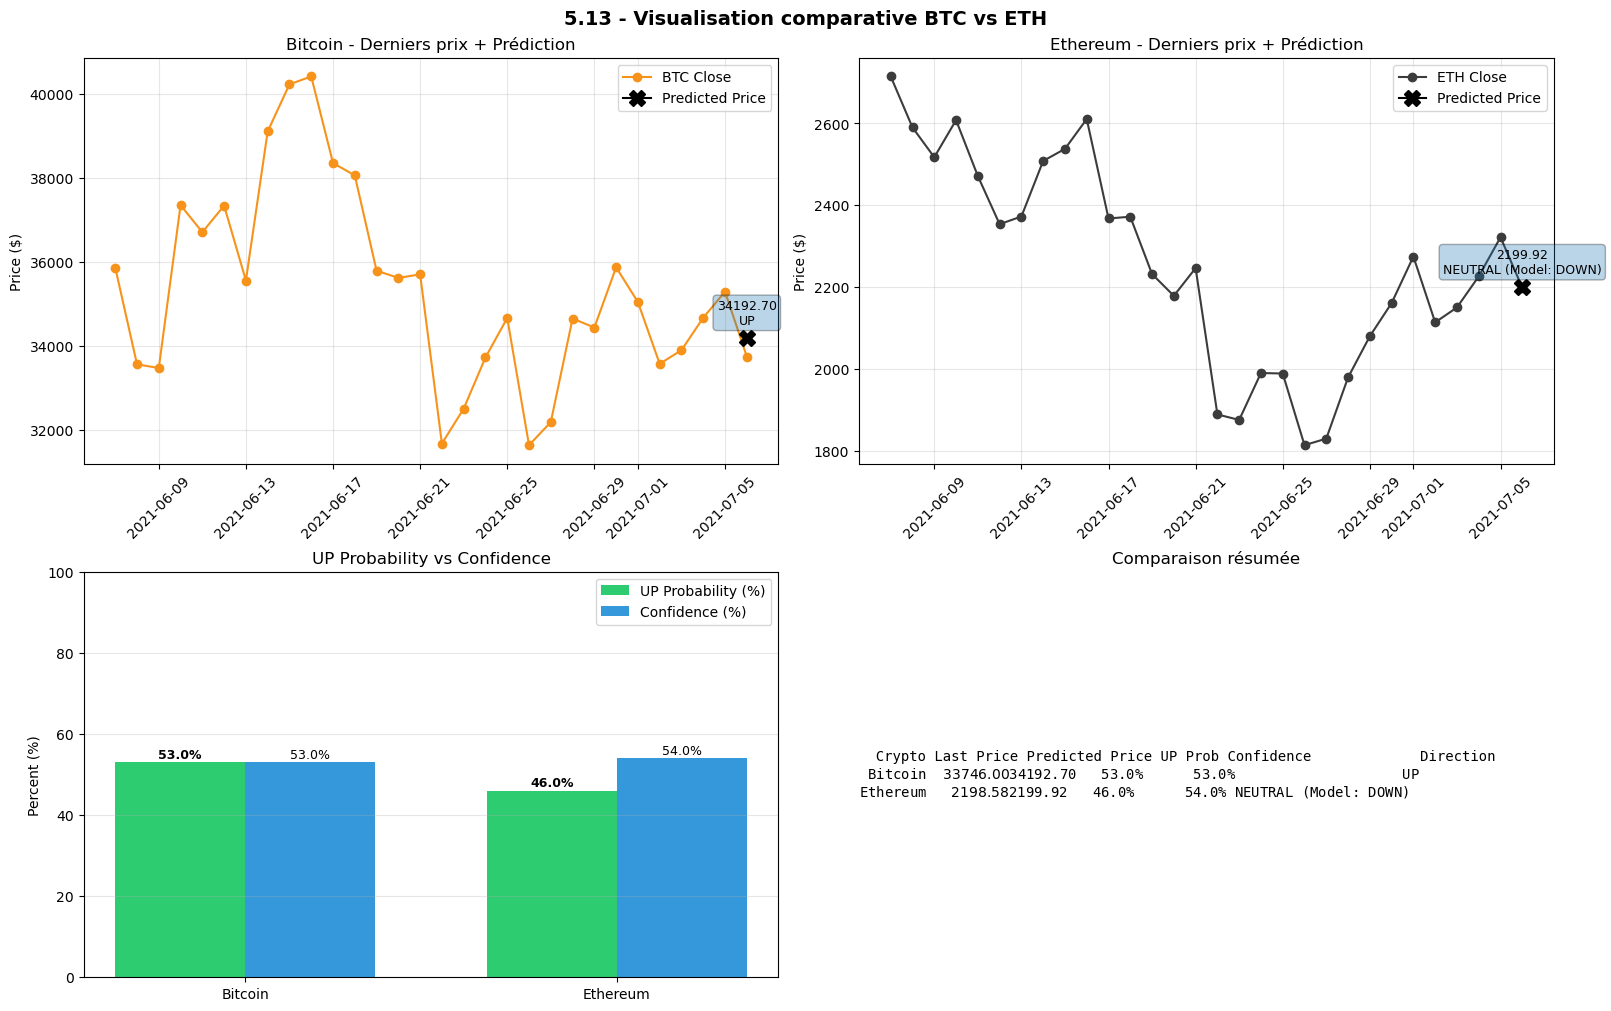

Figure saved: comparison_btc_eth_5_13.png


In [12]:

# 5.13 COMPARAISON VISUELLE BTC vs ETH


plt.rcParams['font.family'] = 'DejaVu Sans'

if bitcoin_prediction is None or ethereum_prediction is None:
    print("Predictions manquantes — exécutez predict_next_day pour BTC et ETH avant la visualisation.")
else:
    def parse_price(s):
        return float(str(s).replace('$', '').replace(',', ''))
    def parse_pct(s):
        return float(str(s).split('%')[0].strip())


    btc_pred_price = parse_price(bitcoin_prediction['Predicted Price'])
    eth_pred_price = parse_price(ethereum_prediction['Predicted Price'])
    btc_last_price = parse_price(bitcoin_prediction['Last Price'])
    eth_last_price = parse_price(ethereum_prediction['Last Price'])

    btc_up_prob = parse_pct(bitcoin_prediction['UP Probability'])
    eth_up_prob = parse_pct(ethereum_prediction['UP Probability'])
    btc_conf = parse_pct(bitcoin_prediction['Confidence'].split()[0])
    eth_conf = parse_pct(ethereum_prediction['Confidence'].split()[0])

    bitcoin_prediction['Direction'] = bitcoin_prediction['Direction'].replace('⏸', 'NEUTRAL')
    ethereum_prediction['Direction'] = ethereum_prediction['Direction'].replace('⏸', 'NEUTRAL')

   
    btc_series = df_sorted[df_sorted['Name'] == 'Bitcoin'].tail(30).copy()
    eth_series = df_sorted[df_sorted['Name'] == 'Ethereum'].tail(30).copy()


    fig, axes = plt.subplots(2, 2, figsize=(16, 10), constrained_layout=True)

    
    ax = axes[0, 0]
    ax.plot(btc_series['Date'], btc_series['Close'], '-o', color='#f7931a', label='BTC Close')
    pred_date_btc = pd.to_datetime(bitcoin_prediction['Prediction Date'])
    ax.plot([pred_date_btc], [btc_pred_price], marker='X', markersize=12, color='black', label='Predicted Price')
    ax.annotate(f"{btc_pred_price:.2f}\n{bitcoin_prediction['Direction']}",
                (pred_date_btc, btc_pred_price),
                textcoords="offset points", xytext=(0, 10), ha='center', fontsize=9,
                bbox=dict(boxstyle='round', alpha=0.3))
    ax.set_title('Bitcoin - Derniers prix + Prédiction')
    ax.set_ylabel('Price ($)')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.tick_params(axis='x', rotation=45)
    ax.grid(alpha=0.3)
    ax.legend()


    ax = axes[0, 1]
    ax.plot(eth_series['Date'], eth_series['Close'], '-o', color='#3c3c3d', label='ETH Close')
    pred_date_eth = pd.to_datetime(ethereum_prediction['Prediction Date'])
    ax.plot([pred_date_eth], [eth_pred_price], marker='X', markersize=12, color='black', label='Predicted Price')
    ax.annotate(f"{eth_pred_price:.2f}\n{ethereum_prediction['Direction']}",
                (pred_date_eth, eth_pred_price),
                textcoords="offset points", xytext=(0, 10), ha='center', fontsize=9,
                bbox=dict(boxstyle='round', alpha=0.3))
    ax.set_title('Ethereum - Derniers prix + Prédiction')
    ax.set_ylabel('Price ($)')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.tick_params(axis='x', rotation=45)
    ax.grid(alpha=0.3)
    ax.legend()

    ax = axes[1, 0]
    labels = ['Bitcoin', 'Ethereum']
    up_probs = [btc_up_prob, eth_up_prob]
    confs = [btc_conf, eth_conf]
    x = np.arange(len(labels))
    width = 0.35
    ax.bar(x - width/2, up_probs, width, label='UP Probability (%)', color=['#2ecc71', '#2ecc71'])
    ax.bar(x + width/2, confs, width, label='Confidence (%)', color=['#3498db', '#3498db'])
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylabel('Percent (%)')
    ax.set_title('UP Probability vs Confidence')
    for i, (p, c) in enumerate(zip(up_probs, confs)):
        ax.text(i - width/2, p + 1, f"{p:.1f}%", ha='center', fontsize=9, fontweight='bold')
        ax.text(i + width/2, c + 1, f"{c:.1f}%", ha='center', fontsize=9)
    ax.set_ylim(0, 100)
    ax.grid(axis='y', alpha=0.3)
    ax.legend()

  
    ax = axes[1, 1]
    ax.axis('off')
    summary = pd.DataFrame([
        ['Bitcoin', f"${btc_last_price:.2f}", f"${btc_pred_price:.2f}", f"{btc_up_prob:.1f}%", f"{btc_conf:.1f}%", bitcoin_prediction['Direction']],
        ['Ethereum', f"${eth_last_price:.2f}", f"${eth_pred_price:.2f}", f"{eth_up_prob:.1f}%", f"{eth_conf:.1f}%", ethereum_prediction['Direction']]
    ], columns=['Crypto', 'Last Price', 'Predicted Price', 'UP Prob', 'Confidence', 'Direction'])
    table_text = summary.to_string(index=False)
    ax.text(0, 0.5, table_text, fontsize=10, fontfamily='monospace', va='center')
    ax.set_title('Comparaison résumée')

    plt.suptitle('5.13 - Visualisation comparative BTC vs ETH', fontsize=14, fontweight='bold')
    plt.savefig('comparison_btc_eth_5_13.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("Figure saved: comparison_btc_eth_5_13.png")



In [13]:
# 5.14 COMPARISON BTC /ETH

print("\n" + "="*80)
print(" COMPARISON - BITCOIN vs ETHEREUM")
print("="*80)

if bitcoin_prediction is not None and ethereum_prediction is not None:
    comparison_table = pd.DataFrame([
        {
            'Metric': 'Cryptocurrency',
            'Bitcoin': bitcoin_prediction['Cryptocurrency'],
            'Ethereum': ethereum_prediction['Cryptocurrency']
        },
        {
            'Metric': 'Prediction Date',
            'Bitcoin': bitcoin_prediction['Prediction Date'],
            'Ethereum': ethereum_prediction['Prediction Date']
        },
        {
            'Metric': 'Last Price',
            'Bitcoin': bitcoin_prediction['Last Price'],
            'Ethereum': ethereum_prediction['Last Price']
        },
        {
            'Metric': 'Predicted Price',
            'Bitcoin': bitcoin_prediction['Predicted Price'],
            'Ethereum': ethereum_prediction['Predicted Price']
        },
        {
            'Metric': 'Price Change',
            'Bitcoin': bitcoin_prediction['Price Change'],
            'Ethereum': ethereum_prediction['Price Change']
        },
        {
            'Metric': 'Price Direction',
            'Bitcoin': bitcoin_prediction['Price_Direction'],
            'Ethereum': ethereum_prediction['Price_Direction']
        },
        {
            'Metric': 'Model Direction',
            'Bitcoin': bitcoin_prediction['Model_Direction'],
            'Ethereum': ethereum_prediction['Model_Direction']
        },
        {
            'Metric': 'Final Direction',
            'Bitcoin': bitcoin_prediction['Direction'],
            'Ethereum': ethereum_prediction['Direction']
        },
        {
            'Metric': 'Confidence',
            'Bitcoin': bitcoin_prediction['Confidence'],
            'Ethereum': ethereum_prediction['Confidence']
        },
        {
            'Metric': 'RSI_14',
            'Bitcoin': bitcoin_prediction['RSI_14'],
            'Ethereum': ethereum_prediction['RSI_14']
        }
    ])
    
    print("\n" + comparison_table.to_string(index=False))
    print("\n" + "="*80)
    print(" PREDICTIONS COMPLETE!")
    print("="*80)
else:
    print(" Cannot generate comparison - missing predictions")
    print("="*80)


 COMPARISON - BITCOIN vs ETHEREUM

         Metric      Bitcoin              Ethereum
 Cryptocurrency      Bitcoin              Ethereum
Prediction Date   2021-07-06            2021-07-06
     Last Price    $33746.00              $2198.58
Predicted Price    $34192.70              $2199.92
   Price Change       +1.32%                +0.06%
Price Direction           UP               NEUTRAL
Model Direction           UP                  DOWN
Final Direction           UP NEUTRAL (Model: DOWN)
     Confidence 53.02% (LOW)          53.97% (LOW)
         RSI_14         54.0                  50.2

 PREDICTIONS COMPLETE!
